# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
import pandas as pd


### 데이터 읽어오기


In [7]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/trim_train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/trim_test_data.csv")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 464 entries, Wip Line_Dam to target
dtypes: float64(342), int64(88), object(34)
memory usage: 143.4+ MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 465 entries, Set ID to target
dtypes: float64(400), int64(31), object(34)
memory usage: 61.6+ MB


In [12]:
# # excel 데이터의 각 열에 대한 값의 개수 출력 -> 변수명 확인용도
# for col in train_data.columns:
#     counts = train_data[col].value_counts()
#     print(f"Value counts for column {col}:")
#     print(counts)
#     print()

In [9]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

# 제거 후 데이터 확인
print("All columns with only NaN values have been removed, except for the target column.")

All columns with only NaN values have been removed, except for the target column.


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 186 entries, Wip Line_Dam to target
dtypes: float64(64), int64(88), object(34)
memory usage: 57.5+ MB


In [15]:
# # excel 데이터의 각 열에 대한 값의 개수 출력 -> 변수명 확인용도
# for col in train_data.columns:
#     counts = train_data[col].value_counts()
#     print(f"Value counts for column {col}:")
#     print(counts)
#     print()

In [11]:
wip_line_columns = train_data.filter(like='Wip Line').columns

new_df = train_data.filter(items=wip_line_columns)

new_df.value_counts()

Wip Line_Dam  Wip Line_AutoClave  Wip Line_Fill1  Wip Line_Fill2
IVI-OB6       IVI-OB6             IVI-OB6         IVI-OB6           40506
Name: count, dtype: int64

In [12]:
train_data.drop(columns=wip_line_columns, inplace=True)
test_data.drop(columns=wip_line_columns, inplace=True)

In [13]:
Process_Desc_col = train_data.filter(like='Process Desc').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Process Desc._Dam  Process Desc._AutoClave  Process Desc._Fill1  Process Desc._Fill2
Dam Dispenser      Auto Clave Out           Fill1 Dispenser      Fill2 Dispenser        40506
Name: count, dtype: int64

In [14]:
train_data = train_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])
test_data = test_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])

In [15]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
new3_df = train_data.filter(items=Equipment_col)

# target 변수 추가
new3_df['target'] = train_data['target']

# 그룹별로 target 변수의 비율 계산
target_ratio = new3_df.groupby(list(Equipment_col))['target'].value_counts(normalize=True).unstack().fillna(0)

# AbNormal 비율 출력
abnormal_ratio = target_ratio.get('AbNormal', 0)
print("각 그룹의 abnormal_ratio:")
print(abnormal_ratio)

# 각 그룹에 값의 갯수 출력
group_counts = new3_df.groupby(list(Equipment_col)).size()
print("각 그룹의 값의 갯수:")
print(group_counts)

각 그룹의 abnormal_ratio:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    0.058614
                                                           Fill2 dispenser #2    1.000000
                                       Fill1 dispenser #2  Fill2 dispenser #2    1.000000
Dam dispenser #2  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    1.000000
                                       Fill1 dispenser #2  Fill2 dispenser #1    1.000000
                                                           Fill2 dispenser #2    0.054977
Name: AbNormal, dtype: float64
각 그룹의 값의 갯수:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    25011
                                                           Fill2 dispenser #2        6
                                       Fill1 dispenser #2  Fill2

In [16]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
Equipment_col2 = test_data.filter(like='Equipment').columns

new3_df = train_data.filter(items=Equipment_col)
new3_df2 = test_data.filter(items=Equipment_col2)

# Equipment_same_num 파생변수 생성
def determine_equipment_same_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
       (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return 1
    else:
        return 0

train_data['Equipment_same_num'] = new3_df.apply(determine_equipment_same_num, axis=1)
test_data['Equipment_same_num'] = new3_df2.apply(determine_equipment_same_num, axis=1)

train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])


In [17]:
Process_Desc_col = train_data.filter(like='Model.Suffix').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Model.Suffix_Dam  Model.Suffix_AutoClave  Model.Suffix_Fill1  Model.Suffix_Fill2
AJX75334501       AJX75334501             AJX75334501         AJX75334501           33820
AJX75334502       AJX75334502             AJX75334502         AJX75334502            3390
AJX75334505       AJX75334505             AJX75334505         AJX75334505            2635
AJX75334507       AJX75334507             AJX75334507         AJX75334507             310
AJX75334503       AJX75334503             AJX75334503         AJX75334503             162
AJX75334506       AJX75334506             AJX75334506         AJX75334506             129
AJX75334508       AJX75334508             AJX75334508         AJX75334508              60
Name: count, dtype: int64

In [18]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})
test_data = test_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_data = test_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [19]:
# Workorder로 시작하는 열 필터링
workorder_cols = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# Workorder 열들로 이루어진 데이터프레임 생성
workorder_df = train_data[workorder_cols]

# 4개의 변수의 값이 모두 동일하지 않은 행 필터링
different_workorders = workorder_df[
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_AutoClave']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_Fill1'] != workorder_df['Workorder_Fill2'])
]

# 결과 출력
print("4개의 변수의 값이 모두 동일하지 않은 경우:")
print(different_workorders)

4개의 변수의 값이 모두 동일하지 않은 경우:
Empty DataFrame
Columns: [Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2]
Index: []


In [20]:
# Model.workorder_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Workorder_Dam': 'Workorder'})
test_data = test_data.rename(columns={'Workorder_Dam': 'Workorder'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_data = test_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

In [21]:
Process_Desc_col = train_data.filter(like='Insp. Seq No.').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

train_data = train_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])
test_data = test_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])

In [22]:
Process_Desc_col = train_data.filter(like='Insp Judge Code').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

train_data = train_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])
test_data = test_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])

In [24]:
train_data
test_data

,Set ID,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,...,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Equipment_same_num
0,0001be084fbc4aaa9d921f39e595961b,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,1150,33.5,0,...,270.0,50.0,85.0,19.8,13.0,195.0,1.0,0.0,NaN,1
1,0005bbd180064abd99e63f9ed3e1ac80,AJX75334501,4B1XD472-2,1000.0,12.5,90,70,1150,33.5,0,...,270.0,50.0,85.0,19.8,14.0,256.0,1.0,NaN,NaN,1
2,000948934c4140d883d670adcb609584,AJX75334501,3H1XE355-1,240.0,2.5,-90,70,1150,33.5,0,...,270.0,50.0,85.0,19.7,1.0,98.0,1.0,0.0,NaN,1
3,000a6bfd02874c6296dc7b2e9c5678a7,AJX75334501,3L1XA128-1,1000.0,12.5,90,70,1150,33.5,0,...,270.0,50.0,85.0,20.0,14.0,0.0,1.0,NaN,NaN,1
4,0018e78ce91343678716e2ea27a51c95,AJX75334501,4A1XA639-1,240.0,2.5,-90,70,1150,33.5,0,...,270.0,50.0,85.0,19.8,1.0,215.0,1.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,AJX75334501,3K1XB597-1,1000.0,12.5,90,70,1150,33.5,0,...,270.0,50.0,85.0,19.5,14.0,131.0,1.0,NaN,NaN,1
17357,ffed8923c8a448a98afc641b770be153,AJX75334501,4A1XB974-1,1000.0,12.5,90,70,1150,33.5,0,...,270.0,50.0,85.0,19.8,12.0,279.0,1.0,NaN,NaN,1
17358,fff1e73734da40adbe805359b3efb462,AJX75334501,3L1XA998-1,240.0,2.5,-90,70,1150,33.5,0,...,270.0,50.0,85.0,20.5,4.0,66.0,1.0,NaN,NaN,1
17359,fff8e38bdd09470baf95f71e92075dec,AJX75334501,3F1XC376-1,240.0,2.5,-90,70,1150,33.5,0,...,270.0,50.0,85.0,18.9,1.0,117.0,1.0,0.0,NaN,1


In [25]:
# 값의 종류가 1개이고 결측값이 없는 열을 제거하는 함수
def drop_single_value_columns(df):
    cols_to_drop = [col for col in df.columns if col != 'target' and df[col].nunique() == 1 and df[col].isnull().sum() == 0]
    df_dropped = df.drop(columns=cols_to_drop)
    return df_dropped, cols_to_drop

# train_data와 test_data에서 해당 열 제거 및 삭제된 열 이름과 개수 출력
train_data, train_cols_dropped = drop_single_value_columns(train_data)
test_data, test_cols_dropped = drop_single_value_columns(test_data)

# print("삭제된 train_data 열 이름:", train_cols_dropped)
print("삭제된 train_data 열 개수:", len(train_cols_dropped))

# print("삭제된 test_data 열 이름:", test_cols_dropped)
print("삭제된 test_data 열 개수:", len(test_cols_dropped))

삭제된 train_data 열 개수: 42
삭제된 test_data 열 개수: 42


In [26]:
train_data.info()
print('---')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 119 entries, Model.Suffix to Equipment_same_num
dtypes: float64(58), int64(52), object(9)
memory usage: 36.8+ MB
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 120 entries, Set ID to Equipment_same_num
dtypes: float64(94), int64(17), object(9)
memory usage: 15.9+ MB


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 119 entries, Model.Suffix to Equipment_same_num
dtypes: float64(58), int64(52), object(9)
memory usage: 36.8+ MB


In [35]:
train_data.to_csv('train_data_fixed.csv', index=False)

## Dam

In [36]:
train_data.columns

Index(['Model.Suffix', 'Workorder', 'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Θ Collect Result_Dam',
       'CURE SPEED Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'CURE START POSITION Θ Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       ...
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
       'Head Purge Position Z Collect Result_Fill2',
       'Machine Tact time Collect Result_Fill2',
       'PalletID Collect Result_Fill2', 'Production Qty Collect Result_Fill2',
       'Receip No Collect Result_Fill2', 'WorkMode Collect Result_Fill2',
       'target', 'Equipment_same_num'],
      dtype='object', length=119)

In [37]:
train_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'].value_counts()

DISCHARGED SPEED OF RESIN Collect Result_Dam
10    21046
16    19456
15        4
Name: count, dtype: int64

In [38]:
for col in train_data.columns :
    cnt = train_data[col].value_counts()
    print(f"{cnt}\n")

Model.Suffix
AJX75334501    33820
AJX75334502     3390
AJX75334505     2635
AJX75334507      310
AJX75334503      162
AJX75334506      129
AJX75334508       60
Name: count, dtype: int64

Workorder
3L1X8574-2    272
3K1XC268-1    227
3L1X8506-1    217
3L1X9934-1    217
3K1XA586-2    189
             ... 
4BPM0084-1      2
4A1XC288-1      2
4CPM0166-1      1
3H1XB714-1      1
3HPM0061-1      1
Name: count, Length: 663, dtype: int64

CURE END POSITION X Collect Result_Dam
240.0     25030
1000.0    15476
Name: count, dtype: int64

CURE END POSITION Z Collect Result_Dam
2.5     25030
12.5    15476
Name: count, dtype: int64

CURE END POSITION Θ Collect Result_Dam
-90    25030
 90    15476
Name: count, dtype: int64

CURE SPEED Collect Result_Dam
70     34429
85      2213
100     2065
105     1640
95       159
Name: count, dtype: int64

CURE START POSITION X Collect Result_Dam
1030    25030
280     15476
Name: count, dtype: int64

CURE START POSITION Θ Collect Result_Dam
-90    25030
 90    15

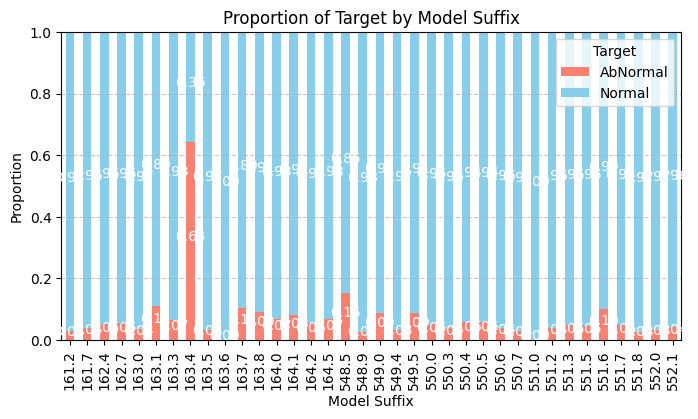

In [39]:


count_df = train_data.groupby(['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'target']).size().unstack(fill_value=0)

count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('HEAD NORMAL COORDINATE X AXIS(Stage1)_Dam')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()


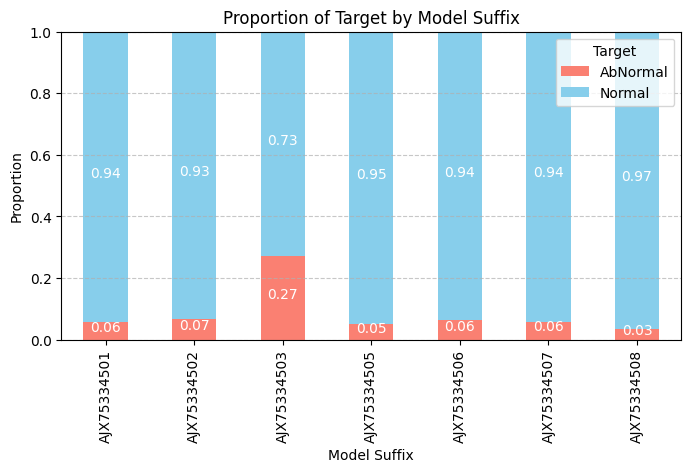

In [40]:
count_df = train_data.groupby(['Model.Suffix', 'target']).size().unstack(fill_value=0)

count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('Model Suffix')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

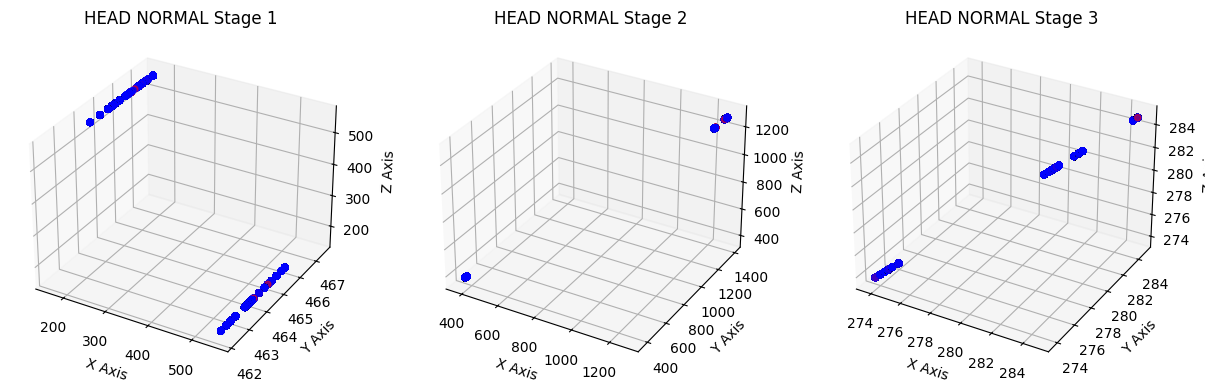

In [41]:
# Create a 3D plot for each stage with the specified settings
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))

color_map = {'AbNormal': 'red', 'Normal': 'blue'}
train_data['color'] = train_data['target'].map(color_map)

colors = train_data['color']

# Plot for Stage 1
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'], 
            train_data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'], 
            train_data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'], c=colors, alpha=0.5)
            
ax1.set_title('HEAD NORMAL Stage 1')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')

# Plot for Stage 2
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(train_data['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'], 
            train_data['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'], 
            train_data['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'], c=colors, alpha=0.5)
            
ax2.set_title('HEAD NORMAL Stage 2')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Z Axis')

# Plot for Stage 3
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(train_data['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'], 
            train_data['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'], 
            train_data['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'],  c=colors, alpha=0.5)
            
ax3.set_title('HEAD NORMAL Stage 3')
ax3.set_xlabel('X Axis')
ax3.set_ylabel('Y Axis')
ax3.set_zlabel('Z Axis')

# Display the plot
plt.show()

In [42]:
volume_as_time = []

train_data["volume_as_time"] = train_data['Dispense Volume(Stage1) Collect Result_Dam'] / train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']


In [43]:
train_data["volume_as_time"].value_counts()

volume_as_time
0.069697    8033
0.069953    6046
0.069072    5442
0.070000    4880
0.069792    4459
0.109848    3181
0.069799    1997
0.109396    1907
0.069718    1276
0.109524     771
0.069466     578
0.069388     522
0.069565     273
0.069630     261
0.109924     246
0.069853     235
0.069828     106
0.069811      93
0.069595      49
0.109459      49
0.109859      37
0.069930      29
0.069591      21
0.069343      11
0.109859       4
Name: count, dtype: int64

In [44]:
train_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'].value_counts()

DISCHARGED SPEED OF RESIN Collect Result_Dam
10    21046
16    19456
15        4
Name: count, dtype: int64

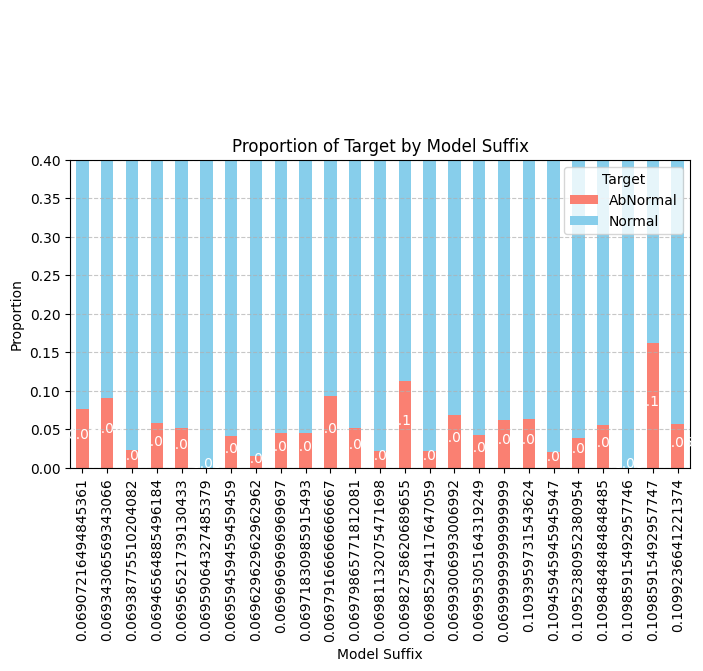

In [45]:
count_df = train_data.groupby(['volume_as_time', 'target']).size().unstack(fill_value=0)

count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('Model Suffix')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

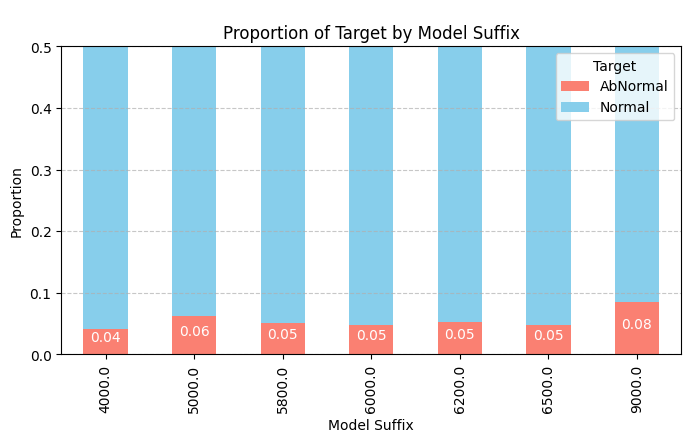

In [46]:
count_df = train_data.groupby(['Stage1 Circle2 Distance Speed Collect Result_Dam', 'target']).size().unstack(fill_value=0)

count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('Model Suffix')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

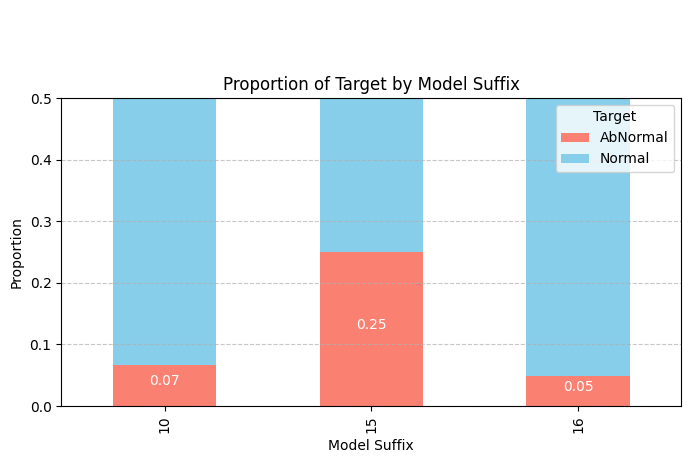

In [47]:
count_df = train_data.groupby(['DISCHARGED SPEED OF RESIN Collect Result_Dam', 'target']).size().unstack(fill_value=0)

count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('Model Suffix')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

In [48]:
train_data['sum'] = count_df.applymap(lambda x: 0 if x <= 0.07 else 1)


/tmp/ipykernel_1905/1728647286.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data['sum'] = count_df.applymap(lambda x: 0 if x <= 0.07 else 1)


ValueError: Cannot set a DataFrame with multiple columns to the single column sum

In [49]:
if train_data['Stage1 Line1 Distance Speed Collect Result_Dam'] != train_data

SyntaxError: expected ':' (2330993946.py, line 1)

In [50]:
a = len(train_data.iloc[:, 10])
index = []
for i in range(a):
    if train_data.loc[i, 'Stage1 Line1 Distance Speed Collect Result_Dam'] != train_data[i, 'Stage1 Line3 Distance Speed Collect Result_Dam'] :
        index.append(i)

KeyError: (0, 'Stage1 Line3 Distance Speed Collect Result_Dam')

In [91]:
train_data['comparison_result'] = train_data.apply(lambda row: 'same' if row['Stage1 Line1 Distance Speed Collect Result_Dam'] == row['Stage1 Line3 Distance Speed Collect Result_Dam'] else 'diff', axis=1)

In [92]:
train_data['comparison_result'].value_counts()

comparison_result
same    36010
diff     4496
Name: count, dtype: int64

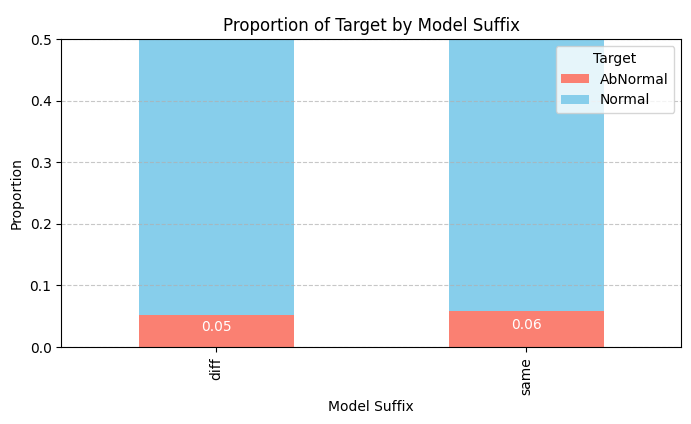

In [93]:
count_df = train_data.groupby(['comparison_result', 'target']).size().unstack(fill_value=0)

count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('Model Suffix')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()